In [58]:
import geopandas as gpd

#임상도 데이터 read
gdf = gpd.read_file("C:/Users/sangj/Desktop/data/임상도_충청북도/43.shp")

In [3]:
if gdf.crs != "epsg:5179":
    gdf = gdf.to_crs(epsg=5179)
    print("Coordinate Reference System Converted")

Coordinate Reference System Converted


In [4]:
gdf = gdf.rename(columns={"FRTP_CD": "수종코드"})

In [5]:
frtp_map = {'1': '침엽수', '2': '활엽수', '3': '혼효림'}
gdf["수종"] = gdf["수종코드"].map(frtp_map).fillna("기타")

In [6]:
gdf["면적"] = gdf.geometry.area

In [7]:
drop_cols = [
    'STORUNST', 'FROR_CD', 'KOFTR_GROU', 'KOFTR_NM',
    'HEIGHT', 'HEIGHT_NM',
    'LDMARK_STN', 'MAP_LABEL',
    '갱신년도', 'ETC_PCMTT',
    'FRTP_NM', 'DMCLS_CD', 'AGCLS_CD', 'DNST_CD',
    'DMCLS_NM', 'AGCLS_NM', 'DNST_NM',
    'Shape_Leng', 'Shape_Area'
]

In [8]:
gdf_cleaned = gdf.drop(columns=drop_cols).copy()

print(gdf_cleaned.columns.tolist())

['수종코드', 'geometry', '수종', '면적']


In [9]:
gdf_cleaned.head()

,수종코드,geometry,수종,면적
0,0,"POLYGON ((1008648.947 1793420.031, 1008649.162...",기타,16629.234079
1,0,"POLYGON ((1008464.292 1793798.283, 1008464.006...",기타,1443.039866
2,0,"POLYGON ((1008774.89 1794082.094, 1008775.129 ...",기타,1284.877417
3,0,"POLYGON ((1008195.689 1793138.554, 1008197.062...",기타,18658.625600
4,0,"POLYGON ((1008337.058 1793530.588, 1008337.234...",기타,3972.956372


In [10]:
#임상도 충청도 저장
gdf_cleaned.to_file("C:/Users/sangj/Desktop/data/임상도_충청북도/충북_임상도_전처리.gpkg", driver="GPKG")

In [11]:
forest = gpd.read_file("C:/Users/sangj/Desktop/data/임상도_충청북도/충북_임상도_전처리.gpkg")
sig = gpd.read_file("C:/Users/sangj/Desktop/data/임상도_서울특별시/대한민국_동리.gpkg")

In [12]:
forest.head(5)

,수종코드,수종,면적,geometry
0,0,기타,16629.234079,"MULTIPOLYGON (((1008648.947 1793420.031, 10086..."
1,0,기타,1443.039866,"MULTIPOLYGON (((1008464.292 1793798.283, 10084..."
2,0,기타,1284.877417,"MULTIPOLYGON (((1008774.89 1794082.094, 100877..."
3,0,기타,18658.625600,"MULTIPOLYGON (((1008195.689 1793138.554, 10081..."
4,0,기타,3972.956372,"MULTIPOLYGON (((1008337.058 1793530.588, 10083..."


In [13]:
sig.head(5)

,리코드,리명,면적,리코드번호,geometry
0,2671025021,동부리,9.046854e+05,26,"MULTIPOLYGON (((1156572.843 1696804.747, 11566..."
1,2671025022,교리,8.125352e+05,26,"MULTIPOLYGON (((1155731.257 1697372.017, 11558..."
2,2671025023,신천리,1.597261e+06,26,"MULTIPOLYGON (((1157572.293 1695843.731, 11575..."
3,2671025024,죽성리,3.097188e+06,26,"MULTIPOLYGON (((1158010.875 1696998.51, 115801..."
4,2671025025,서부리,1.603228e+06,26,"MULTIPOLYGON (((1155615.822 1696551.022, 11556..."


In [14]:
# 좌표계 통일
forest = forest.to_crs(sig.crs)

In [15]:
# 공간 조인
joined = gpd.sjoin(forest, sig, how="inner", predicate="intersects")
joined["면적"] = joined.geometry.area

In [17]:
# 구별 수종 비율 계산 후 저장
summary = joined.groupby(["리명", "수종"])["면적"].sum().unstack(fill_value=0)
summary["총면적"] = summary.sum(axis=1)
for kind in ["침엽수", "활엽수", "혼효림", "기타"]:
    if kind not in summary.columns:
        summary[kind] = 0
    summary[f"{kind}_비율"] = (summary[kind] / summary["총면적"]) * 100
result = summary[[f"{k}_비율" for k in ["침엽수", "활엽수", "혼효림", "기타"]]].round(2).reset_index()

In [18]:
result.head(5)

수종,리명,침엽수_비율,활엽수_비율,혼효림_비율,기타_비율
0,가고리,36.73,31.67,31.33,0.26
1,가곡리,46.48,33.93,7.25,12.34
2,가대리,44.02,40.35,12.64,2.99
3,가동리,35.41,43.02,4.27,17.30
4,가락리,21.58,50.60,15.01,12.80


In [19]:
# 혼효림 반반 나누기
result["침엽수_tmp"] = result["침엽수_비율"] + result["혼효림_비율"] * 0.5
result["활엽수_tmp"] = result["활엽수_비율"] + result["혼효림_비율"] * 0.5

# 전체 합계 (기타는 제외)
total = result["침엽수_tmp"] + result["활엽수_tmp"]

# 정규화: 100% 기준 재비율화
result["침엽수_비율"] = (result["침엽수_tmp"] / total) * 100
result["활엽수_비율"] = (result["활엽수_tmp"] / total) * 100

# 반올림
result[["침엽수_비율", "활엽수_비율"]] = result[["침엽수_비율", "활엽수_비율"]].round(2)

# 불필요한 컬럼 제거
result = result.drop(columns=["혼효림_비율", "기타_비율", "침엽수_tmp", "활엽수_tmp"], errors='ignore')

In [20]:
result.head(5)

수종,리명,침엽수_비율,활엽수_비율
0,가고리,52.54,47.46
1,가곡리,57.16,42.84
2,가대리,51.89,48.11
3,가동리,45.40,54.60
4,가락리,33.36,66.64


In [21]:
# 결과 저장
result.to_csv("C:/Users/sangj/Desktop/data/임상도_충청북도/리별_수종비율.csv", index=False, encoding="utf-8-sig")

,동리,침엽수_비율,활엽수_비율,산불_피해면적합계,산불_발생횟수,산불_진화시간합계,산불_평균피해면적,시간당_피해면적
267,덕천리,71.01,28.99,10700.0,2.0,218.0,5350.000000,49.082569
278,도신리,64.90,35.10,11200.0,2.0,169.0,5600.000000,66.272189
449,봉곡리,60.98,39.02,4800.0,1.0,165.0,4800.000000,29.090909
452,봉산리,89.95,10.05,1948800.0,6.0,2996.0,324800.000000,650.467290
453,봉소리,62.65,37.35,2200.0,2.0,96.0,1100.000000,22.916667
678,수정리,83.19,16.81,3200.0,1.0,200.0,3200.000000,16.000000
729,쌍용리,67.02,32.98,3000.0,1.0,82.0,3000.000000,36.585366
770,연당리,94.34,5.66,1600.0,1.0,60.0,1600.000000,26.666667
880,원리,69.27,30.73,9400.0,3.0,430.0,3133.333333,21.860465
1196,현곡리,63.66,36.34,9200.0,2.0,280.0,4600.000000,32.857143


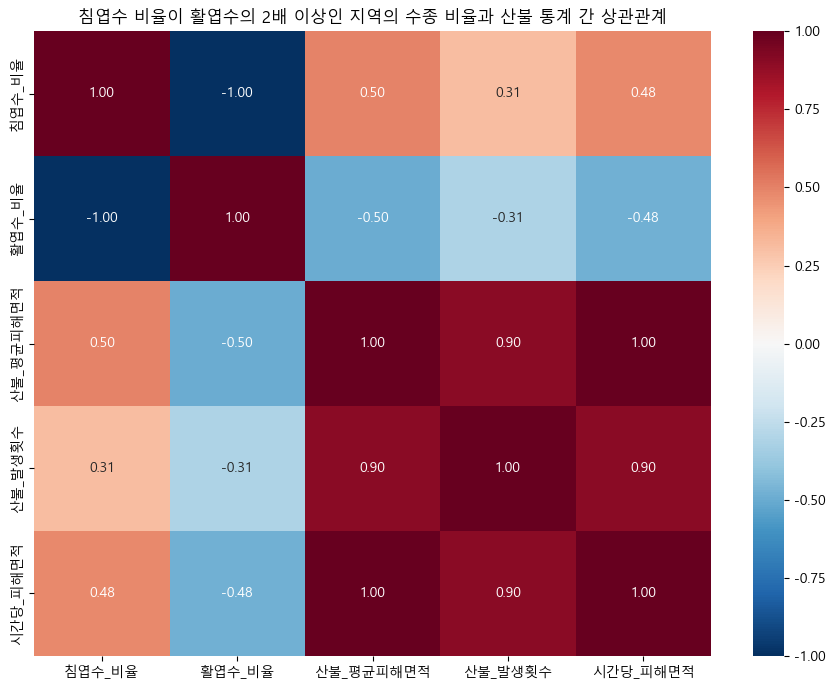

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False 

# 🔹 1. 데이터 불러오기
tree_ratio = pd.read_csv("C:/Users/sangj/Desktop/data/임상도_충청북도/리별_수종비율.csv", encoding="utf-8-sig")
fire = pd.read_csv("C:/Users/sangj/Desktop/data/산불데이터_동리_전처리.csv", encoding="utf-8-sig")

# 🔹 2. 산불 통계 집계 (동리 기준)
fire_summary = fire.groupby("동리").agg(
    산불_피해면적합계=("피해면적_m2", "sum"),
    산불_발생횟수=("피해면적_m2", "count"),
    산불_진화시간합계=("진화시간_분", "sum")
).reset_index()

# 🔹 3. 병합
tree_ratio = tree_ratio.rename(columns={"리명": "동리"})
merged = pd.merge(tree_ratio, fire_summary, on="동리", how="left")

# 🔹 4. 산불 데이터 누락 처리
merged[["산불_피해면적합계", "산불_발생횟수", "산불_진화시간합계"]] = merged[[
    "산불_피해면적합계", "산불_발생횟수", "산불_진화시간합계"
]].fillna(0)

# 🔹 5. 파생 변수 생성
merged["산불_평균피해면적"] = merged["산불_피해면적합계"] / merged["산불_발생횟수"]
merged["시간당_피해면적"] = merged["산불_피해면적합계"] / merged["산불_진화시간합계"]

# 🔹 6. 예외값 + 침엽수 조건 필터링
merged = merged[
    (merged["산불_발생횟수"] > 0) &
    (merged["산불_진화시간합계"] > 0) &
    (merged["산불_평균피해면적"] > 1000) &
    (merged["침엽수_비율"] > merged["활엽수_비율"] * 1.5)
]
display(merged.head(30))
# 🔹 7. 상관분석 대상 컬럼 선택
corr_cols = ["침엽수_비율", "활엽수_비율", "산불_평균피해면적", "산불_발생횟수", "시간당_피해면적"]
correlation = merged[corr_cols].corr()

# 🔹 8. 히트맵 시각화
plt.figure(figsize=(9, 7))
sns.heatmap(correlation, annot=True, cmap="RdBu_r", fmt=".2f")
plt.title("침엽수 비율이 활엽수의 2배 이상인 지역의 수종 비율과 산불 통계 간 상관관계")
plt.tight_layout()
plt.show()


In [56]:
from scipy.stats import pearsonr

# 대상 컬럼
cols = ["침엽수_비율", "활엽수_비율", "산불_평균피해면적", "산불_발생횟수", "시간당_피해면적"]

# 결과 저장용
results = []

# 모든 조합에 대해 상관계수와 p-value 계산
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        col1 = cols[i]
        col2 = cols[j]
        r, p = pearsonr(merged[col1], merged[col2])
        results.append({
            "변수1": col1,
            "변수2": col2,
            "상관계수": round(r, 2),
            "p값": round(p, 4),
            "유의": "✅ 유의함 (p<0.05)" if p < 0.1 else "❌ 유의하지 않음"
        })

# 데이터프레임으로 보기 좋게 정리
result_df = pd.DataFrame(results)
display(result_df)


,변수1,변수2,상관계수,p값,유의
0,침엽수_비율,활엽수_비율,-1.00,0.0000,✅ 유의함 (p<0.05)
1,침엽수_비율,산불_평균피해면적,0.50,0.1427,❌ 유의하지 않음
2,침엽수_비율,산불_발생횟수,0.31,0.3866,❌ 유의하지 않음
3,침엽수_비율,시간당_피해면적,0.48,0.1582,❌ 유의하지 않음
4,활엽수_비율,산불_평균피해면적,-0.50,0.1427,❌ 유의하지 않음
5,활엽수_비율,산불_발생횟수,-0.31,0.3866,❌ 유의하지 않음
6,활엽수_비율,시간당_피해면적,-0.48,0.1582,❌ 유의하지 않음
7,산불_평균피해면적,산불_발생횟수,0.90,0.0004,✅ 유의함 (p<0.05)
8,산불_평균피해면적,시간당_피해면적,1.00,0.0000,✅ 유의함 (p<0.05)
9,산불_발생횟수,시간당_피해면적,0.90,0.0004,✅ 유의함 (p<0.05)
